# Submission - Pump it Up: Data Mining the Water Table

## Objectives
- Prepare data for submission

## Tabel of contents

1. Introduction - Problem Description
2. Import Data
3. Support for Missing Data
4. Label Encode String Class Values
5. Multiclass Imbalance
6. Target Encode Categorical Data
7. Train the XGBoost Model
8. Prepare Data for Submission

## 1. Introduction

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

Over 24 million people are impacted by the The United Republic of Tanzania’s water crisis; that’s almost half of the population of Tanzania

A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

The goal is to predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. 

## 2. Import Data
- import all the necessary classes, functions, and packages

In [15]:
# Import libraries
import pandas as pd
import numpy as np
import pickle
import category_encoders as ce

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [16]:
# Load preprocessed data into X_train, X_test(submission) and y
with open('X_processed.pickle', 'rb') as f:
    X_train = pickle.load(f)
    
# Load and split preprocessed data into X and y
with open('X_submission.pickle', 'rb') as f:
    X_test = pickle.load(f)
    
df_labels = pd.read_csv('Water_Table_Training_set_labels.csv')
y_train = df_labels.drop('id', axis=1)
y_train.columns = ['target']

X_test_id = X_test['id']
X_test.drop(columns=['id'], inplace=True)

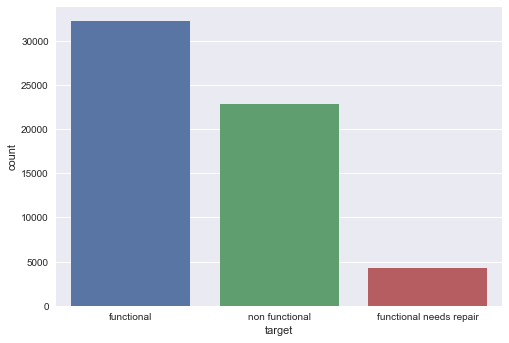

In [17]:
sns.countplot(y_train['target']);

In [18]:
# Create summary of Nan and unique values counts and data types
X_info = pd.DataFrame(X_train.isna().sum(), columns=['NaN count'])

unique_val = []
types_val = []
zero_val = []

for column in X_train.columns:
    unique = len(X_train[column].unique())
    types = str(X_train[column].dtype)
    zeros = len(X_train[X_train[column]==0])
    
    unique_val.append(unique)
    types_val.append(types)
    zero_val.append(zeros)

X_info['Zero values count'] = zero_val
X_info['Unique_val count'] = unique_val
X_info['Data type'] = types_val

X_info.sort_values(by=['NaN count', 'Zero values count'], ascending=False)

,NaN count,Zero values count,Unique_val count,Data type
scheme_name,28166,0,2697,object
scheme_management,3877,0,13,object
installer,3655,0,2146,object
funder,3635,0,1898,object
public_meeting,3334,5055,3,object
permit,3056,17492,3,object
subvillage,371,0,19288,object
num_private,0,58643,65,int64
amount_tsh,0,41639,98,float64
population,0,21381,1049,int64


## 3. Support for Missing Data

In [19]:
X_train[['region_code', 'district_code']] = X_train[['region_code', 'district_code']].astype(str)
X_test[['region_code', 'district_code']] = X_test[['region_code', 'district_code']].astype(str)

In [20]:
X_train = X_train.replace(0, np.NaN)
X_train = X_train.replace('0', np.NaN)

X_test = X_test.replace(0, np.NaN)
X_test = X_test.replace('0', np.NaN)

In [21]:
#train set
X_train.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year
count,17761.000000,38962.000000,59400.000000,59400.000000,757.000000,38019.000000,38691.000000
mean,1062.351942,1018.860839,35.108612,-5.802531,37.204756,281.087167,1996.814686
std,5409.344940,612.566092,2.589216,2.813070,101.958683,564.687660,12.472045
min,0.200000,-90.000000,29.607122,-11.649440,1.000000,1.000000,1960.000000
25%,50.000000,393.000000,33.281762,-8.540621,6.000000,40.000000,1987.000000
50%,250.000000,1167.000000,34.924718,-5.038869,15.000000,150.000000,2000.000000
75%,1000.000000,1498.000000,37.186032,-3.335356,42.000000,324.000000,2008.000000
max,350000.000000,2770.000000,40.345193,-0.998464,1776.000000,30500.000000,2013.000000


In [22]:
X_train_num = X_train.select_dtypes(exclude='object')
X_train_obj = X_train.select_dtypes('object')

for column in X_train_num.columns:
    X_train_num[column].fillna(X_train_num[column].mean(), inplace=True)

In [23]:
X_test_num = X_test.select_dtypes(exclude='object')
X_test_obj = X_test.select_dtypes('object')

for column in X_test_num.columns:
    X_test_num[column].fillna(X_test_num[column].mean(), inplace=True)

In [24]:
X_train = pd.concat([X_train_num, X_train_obj],axis=1)
X_test = pd.concat([X_test_num, X_test_obj],axis=1)
X_train.head()

,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year,date_recorded,funder,installer,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,6000.000000,1390.000000,34.938093,-9.856322,37.204756,109.000000,1999.000000,2011-03-14,Roman,Roman,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,1062.351942,1399.000000,34.698766,-2.147466,37.204756,280.000000,2010.000000,2013-03-06,Grumeti,GRUMETI,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,25.000000,686.000000,37.460664,-3.821329,37.204756,250.000000,2009.000000,2013-02-25,Lottery Club,World vision,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,1062.351942,263.000000,38.486161,-11.155298,37.204756,58.000000,1986.000000,2013-01-28,Unicef,UNICEF,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,1062.351942,1018.860839,31.130847,-1.825359,37.204756,281.087167,1996.814686,2011-07-13,Action In A,Artisan,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [25]:
# Create summary of Nan and unique values counts and data types
X_info = pd.DataFrame(X_train.isna().sum(), columns=['NaN count'])

unique_val = []
types_val = []
zero_val = []

for column in X_train.columns:
    unique = len(X_train[column].unique())
    types = str(X_train[column].dtype)
    zeros = len(X_train[X_train[column]==0])
    
    unique_val.append(unique)
    types_val.append(types)
    zero_val.append(zeros)

X_info['Zero values count'] = zero_val
X_info['Unique_val count'] = unique_val
X_info['Data type'] = types_val

X_info

,NaN count,Zero values count,Unique_val count,Data type
amount_tsh,0,0,98,float64
gps_height,0,0,2428,float64
longitude,0,0,57583,float64
latitude,0,0,57583,float64
num_private,0,0,65,float64
population,0,0,1049,float64
construction_year,0,0,55,float64
date_recorded,0,0,356,object
funder,4412,0,1897,object
installer,4432,0,2145,object


In [26]:
X_train['permit'].fillna(0, inplace=True)
X_test['permit'].fillna(0, inplace=True)

In [27]:
X_train.drop(columns=['date_recorded', 'region_code', 'wpt_name', 'ward','funder'], inplace=True)
X_test.drop(columns=['date_recorded', 'region_code', 'wpt_name', 'ward','funder'], inplace=True)

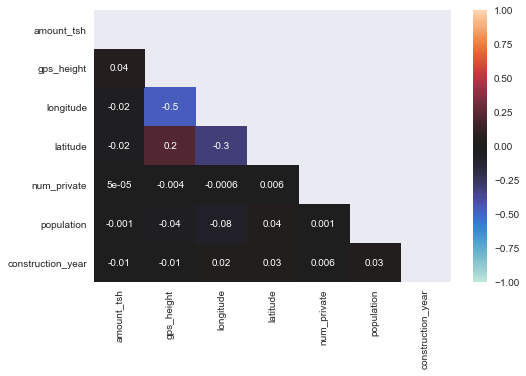

In [28]:
plt.figure(figsize=(8,5))
matrix = np.triu(X_train.corr())
sns.heatmap(X_train.corr(), center=0, annot=True, fmt='.1g', vmin=-1, vmax=1, mask=matrix)

## 4. Label Encode String Class Values

In [29]:
y_train['target'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [30]:
# Convert y labels
y_train = y_train.replace({'target': {'functional' : 1, 
                                'non functional' : 0, 
                                'functional needs repair' : 2}})

In [31]:
y_train['target'] = y_train['target'].astype(int)

In [32]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  59400 non-null  int64
dtypes: int64(1)
memory usage: 464.2 KB


## 5. Multiclass Imbalance

In [33]:
from sklearn.utils import class_weight

classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train['target']
)

# xgb_classifier.fit(X, y, sample_weight=classes_weights)

In [34]:
np.unique(classes_weights)

array([0.6137822 , 0.86750789, 4.58651842])

## 6. Target Encode Categorical Data

In [35]:
def target_encode_multiclass(X,y): #X,y are pandas df and series
    y=y.astype(str)   #convert to string to onehot encode
    enc=ce.OneHotEncoder().fit(y)
    y_onehot=enc.transform(y)
    class_names=y_onehot.columns  #names of onehot encoded columns
    X_obj=X.select_dtypes('object') #separate categorical columns
    X=X.select_dtypes(exclude='object') 
  
    for class_ in class_names:
      
        enc=ce.TargetEncoder()
        enc.fit(X_obj,y_onehot[class_]) #convert all categorical 
        temp=enc.transform(X_obj)       #columns for class_
        temp.columns=[str(x)+'_'+str(class_) for x in temp.columns]
        X=pd.concat([X,X_obj,temp],axis=1)    #add to original dataset
      
    return X

In [36]:
def target_encode_dict(X,y): #X,y are pandas df and series
    y=y.astype(str)   #convert to string to onehot encode
    enc=ce.OneHotEncoder().fit(y)
    y_onehot=enc.transform(y)
    class_names=y_onehot.columns  #names of onehot encoded columns
    X_obj=X.select_dtypes('object') #separate categorical columns
    X=X.select_dtypes(exclude='object') 
    X_1 = X_obj.copy()
    cat_target_dict = {}
    
    for class_ in class_names:
      
        enc=ce.TargetEncoder()
        enc.fit(X_obj,y_onehot[class_]) #convert all categorical 
        temp=enc.transform(X_obj)       #columns for class_
        temp.columns=[str(x)+'_'+str(class_) for x in temp.columns]
        X_1=pd.concat([X_1,temp],axis=1)    #add to original dataset
        X=pd.concat([X,temp],axis=1)
        
    for column in X_obj.columns:
        column_list=[column]
        
        for target in class_names:
            column_list.append(str(column)+'_'+str(target))
        
        cat_targets_df = X_1[column_list]
        cat_targets_df.drop_duplicates(subset = [column], inplace=True)
        cat_targets_df.set_index(column, inplace=True)
        dict_=cat_targets_df.to_dict()
        cat_target_dict={**cat_target_dict, **dict_}
      
    return X, cat_target_dict

In [37]:
#Add target encoding columns do dataframe
def add_train_targets(X_test, y_train, target_encode_dict):
    y=y_train.astype(str)   #convert to string to onehot encode
    enc=ce.OneHotEncoder().fit(y)
    y_onehot=enc.transform(y)
    class_names=y_onehot.columns  #names of onehot encoded columns
    X_obj=X_test.select_dtypes('object') #separate categorical columns
    X=X_test.select_dtypes(exclude='object') 
    temp = pd.DataFrame()  
    
    for column in X_obj.columns:
        for class_ in class_names:
            temp[str(column)+'_'+str(class_)]=X_obj[column]
            temp[str(column)+'_'+str(class_)]=temp[str(column)+'_'+str(class_)].map(target_encode_dict[str(column)+'_'+str(class_)])
    
    X_test=pd.concat([X, temp],axis=1)
    X_test.fillna(0.33, inplace=True)
    
    return X_test

In [38]:
def group_low_frequency_val(X, threshold=15, name='other'):
    lowFreqVal_dict = {}
    X_obj=X.select_dtypes('object')

    for column in X_obj.columns:
        lowFreqVal = X_obj[column].value_counts().to_frame()
        lowFreqVal = lowFreqVal[lowFreqVal[column] < threshold]
        lowFreqVal[column] = name
        lowFreqVal = lowFreqVal.to_dict()
        lowFreqVal_dict={**lowFreqVal_dict, **lowFreqVal}
        
    return lowFreqVal_dict

In [39]:
def update_X_low_freq_val(X, dict_):
    X_obj=X.select_dtypes('object')
    
    for column in X_obj.columns:
        X[column]=X[column].replace(dict_[column])
    
    return X

## 7. Train the XGBoost Model

In [40]:
def data_processing(X_train, y_train, X_test, threshold=10):

    #Check for number of unique keys for column after applying threshold
    low_frequency_val_train = group_low_frequency_val(X_train, threshold)
    #Group low frequency values to 'other' category for each column
    X_train = update_X_low_freq_val(X_train, low_frequency_val_train)
    
    X_train, target_dict = target_encode_dict(X_train, y_train)
    X_test = update_X_low_freq_val(X_test, low_frequency_val_train)
    X_test = add_train_targets(X_test, y_train, target_dict)
    X_test.fillna(0, inplace=True)
    X_train.sort_index(axis=1, inplace=True)
    X_test.sort_index(axis=1,inplace=True)
    
    # Scale data
    scaler = StandardScaler()
    # Transform the training and test sets
    scaled_data_train = scaler.fit_transform(X_train) #fit calculates mean and variance
    scaled_data_test = scaler.transform(X_test)
    # Convert into a DataFrame
    scaled_X_train = pd.DataFrame(scaled_data_train, columns=X_train.columns)
    scaled_X_train
    
    # This will transform the selected columns and merge to the original data frame
    scaled_X_test = pd.DataFrame(scaled_data_test, columns=X_test.columns)
    scaled_X_test
    
    return scaled_X_train, scaled_X_test, y_train

In [43]:
scaled_X_train, scaled_X_test, y_train = data_processing(X_train, y_train, X_test, threshold=350)

In [48]:
clf = xgb.XGBClassifier(learning_rate = 0.6, 
                            min_child_weight = 1,
                            gamma = 4, 
                            n_estimators = 250,
                            subsample = 0.9,
                            objective = 'multi:softmax',
                            reg_lambda = 1)

clf.fit(scaled_X_train, y_train, sample_weight=classes_weights)
val_preds = clf.predict(scaled_X_test)

In [249]:
#Check for number of unique keys for column after applying threshold
print(val_preds.shape)
print(np.unique(val_preds))

(14850,)
[0 1 2]


In [49]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(scaled_X_train, y_train, test_size=0.25, random_state=42)

In [312]:
# Fit model using each importance as a threshold
thresholds = (np.sort(clf.feature_importances_))[-10:-30:-1]
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(clf, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_)
    # train model
    selection_model = xgb.XGBClassifier()
    selection_model.fit(select_X_train, y_train_)
    # eval model
    select_X_test = selection.transform(X_test_)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test_, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))


Thresh=0.018, n=10, Accuracy: 73.04%
Thresh=0.016, n=11, Accuracy: 73.10%
Thresh=0.015, n=12, Accuracy: 73.35%
Thresh=0.015, n=13, Accuracy: 73.31%
Thresh=0.014, n=14, Accuracy: 73.23%
Thresh=0.013, n=15, Accuracy: 73.14%
Thresh=0.012, n=16, Accuracy: 73.32%
Thresh=0.012, n=17, Accuracy: 72.98%
Thresh=0.012, n=18, Accuracy: 73.27%
Thresh=0.011, n=19, Accuracy: 73.80%
Thresh=0.011, n=20, Accuracy: 73.76%
Thresh=0.011, n=21, Accuracy: 74.05%
Thresh=0.011, n=22, Accuracy: 74.30%
Thresh=0.011, n=23, Accuracy: 74.38%
Thresh=0.011, n=24, Accuracy: 74.27%
Thresh=0.010, n=25, Accuracy: 74.43%
Thresh=0.010, n=26, Accuracy: 74.52%
Thresh=0.009, n=27, Accuracy: 74.48%
Thresh=0.009, n=28, Accuracy: 74.51%
Thresh=0.009, n=29, Accuracy: 74.62%


In [352]:
# Fit model using each importance as a threshold
thresholds = [0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(clf, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_)
    # train model
    selection_model = xgb.XGBClassifier()
    selection_model.fit(select_X_train, y_train_)
    # eval model
    select_X_test = selection.transform(X_test_)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test_, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))



Thresh=0.002, n=82, Accuracy: 75.21%
Thresh=0.003, n=79, Accuracy: 75.21%
Thresh=0.004, n=72, Accuracy: 75.23%
Thresh=0.005, n=58, Accuracy: 75.02%
Thresh=0.006, n=50, Accuracy: 75.06%
Thresh=0.007, n=41, Accuracy: 74.97%


In [50]:
# Fit model using each importance as a threshold
thresholds = [0.001]
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(clf, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_)
    # train model
    selection_model = xgb.XGBClassifier()
    selection_model.fit(select_X_train, y_train_)
    # eval model
    select_X_test = selection.transform(X_test_)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test_, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.001, n=70, Accuracy: 75.20%


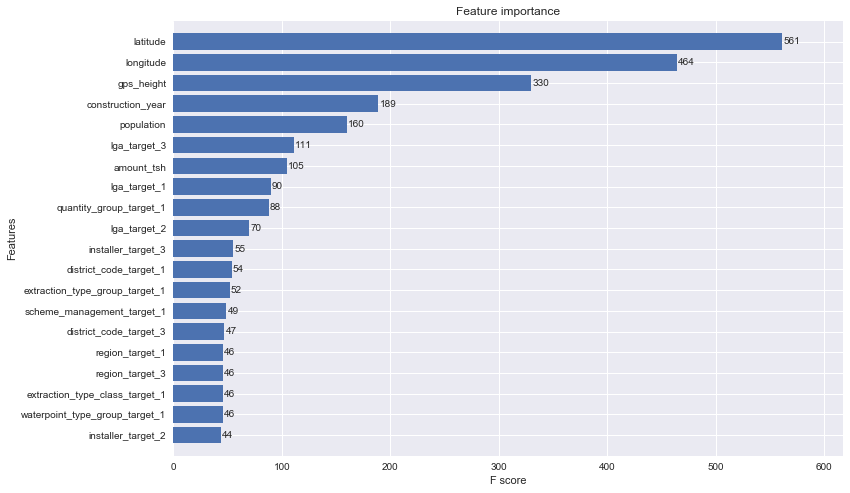

In [54]:
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(clf, max_num_features=20, height=0.8, ax=ax)
plt.show()

## 8. Prepare Data for Submission

In [250]:
submission = pd.read_csv('Water_Table_Submission_format.csv')

In [251]:
submission.head()

,id,status_group
0,50785,predicted label
1,51630,predicted label
2,17168,predicted label
3,45559,predicted label
4,49871,predicted label


In [252]:
X_test_id[X_test_id == submission['id']].any(axis=None)

True

In [253]:
submission['status_group'] = val_preds

In [254]:
submission = submission.replace({'status_group': {1: 'functional', 
                                0: 'non functional', 
                                2: 'functional needs repair'}})

In [255]:
submission.head()

,id,status_group
0,50785,functional needs repair
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [256]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            14850 non-null  int64 
 1   status_group  14850 non-null  object
dtypes: int64(1), object(1)
memory usage: 232.2+ KB


In [257]:
submission.to_csv('submission_2.csv', index=False)